In [1]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score

/home/users/zys/.local/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df_paths = pd.DataFrame(pd.Series(glob.glob("/scratch/users/zys/Curated/HSC/HSC-*")))
# df_paths = pd.DataFrame(pd.Series(glob.glob("/scratch/users/zys/Synthetic/dyn-BF/dyn-BF-*")))
# df_paths = pd.DataFrame(pd.Series(glob.glob("/scratch/users/zys/Synthetic/dyn-TF/dyn-TF-*")))

path = df_paths.iloc[0][0]
df = pd.read_csv(os.path.join(path, "refNetwork.csv"))
genes = pd.read_csv(os.path.join(path, "ExpressionData.csv"), index_col = 0).index
backbone = os.path.basename(df_paths.iloc[0, 0]).split('-1000')[0]

In [3]:
A_ref = pd.DataFrame(np.zeros((len(genes), len(genes)), int), index = genes, columns = genes)
for i in range(df.shape[0]):
    _i = df.iloc[i, 1]
    _j = df.iloc[i, 0]
    _v = {"+" : 1, "-" : -1}[df.iloc[i, 2]]
    A_ref.loc[_i, _j] = _v
np.fill_diagonal(A_ref.values, 0)

In [4]:
# Some helper functions

def AUPRC(A_ref, x):
    return average_precision_score(np.abs(A_ref.values).flatten(), np.abs(x.loc[A_ref.index, :].loc[:, A_ref.columns].values).flatten())
def AUPRC_ratio(A_ref, x):
    A = np.abs(A_ref.values)
    return average_precision_score(A.flatten(), np.abs(x.loc[A_ref.index, :].loc[:, A_ref.columns].values).flatten()) / A.mean()
def AUPRC_pos(A_ref, x):
    A = A_ref.values > 0
    return average_precision_score(A.flatten(), np.abs(np.maximum(0, x.loc[A_ref.index, :].loc[:, A_ref.columns].values)).flatten())
def AUPRC_ratio_pos(A_ref, x):
    A = A_ref.values > 0
    return average_precision_score(A.flatten(), np.abs(np.maximum(0, x.loc[A_ref.index, :].loc[:, A_ref.columns].values)).flatten()) / A.mean()
def AUPRC_neg(A_ref, x):
    A = A_ref.values < 0
    return average_precision_score(A.flatten(), np.abs(np.minimum(0, x.loc[A_ref.index, :].loc[:, A_ref.columns].values)).flatten()) 
def AUPRC_ratio_neg(A_ref, x):
    A = A_ref.values < 0
    return average_precision_score(A.flatten(), np.abs(np.minimum(0, x.loc[A_ref.index, :].loc[:, A_ref.columns].values)).flatten()) / A.mean()
def AUPRC_ratio_signed(A_ref, x):
    return (AUPRC_pos(x), AUPRC_neg(x))

def get_scores_df(str_A):
    scores_list = []
    paths_list = []
    for path in list(df_paths.iloc[:, 0]):
        files = glob.glob(os.path.join(path, f"{str_A}*.csv"))
        scores_list.append(pd.Series({float(os.path.basename(f).split(f"{str_A}_")[-1].split(".csv")[0]) : _AUPRC(A_ref, pd.read_csv(f, index_col = 0)) for f in files}))
        paths_list.append(path)
    df_scores = pd.DataFrame(scores_list)
    ord = np.sort(df_scores.columns)
    df_scores = df_scores.loc[:, ord]
    return df_scores

def get_scores_df_renge(str_A):
    scores_list = []
    paths_list = []
    for path in list(df_paths.iloc[:, 0]):
        files = glob.glob(os.path.join(path, f"{str_A}*.csv"))
        scores_list.append(pd.Series({float(os.path.basename(f).split(f"ko_")[-1].split(".csv")[0]) : _AUPRC(A_ref, pd.read_csv(f, index_col = 0)) for f in files}))
        paths_list.append(path)
    df_scores = pd.DataFrame(scores_list)
    ord = np.sort(df_scores.columns)
    df_scores = df_scores.loc[:, ord]
    return df_scores

def get_scores_df_bicycle(str_A):
    scores_list = []
    paths_list = []
    for path in list(df_paths.iloc[:, 0]):
        files = glob.glob(os.path.join(path, f"{str_A}*.csv"))
        scores_list.append(pd.Series({float(os.path.basename(f).split(f"ko_")[-1].split(".csv")[0]) : _AUPRC(A_ref, pd.read_csv(f, index_col = 0)) for f in files}))
        paths_list.append(path)
    df_scores = pd.DataFrame(scores_list)
    ord = np.sort(df_scores.columns)
    df_scores = df_scores.loc[:, ord]
    return df_scores

def get_scores_df_simple(method):
    scores_list = []
    paths_list = []
    for path in list(df_paths.iloc[:, 0]):
        f = glob.glob(os.path.join(path, f"A_{method}.csv"))[0]
        scores_list.append(pd.Series({method : _AUPRC(A_ref, pd.read_csv(f, index_col = 0))}))
        paths_list.append(path)
    df_scores = pd.DataFrame(scores_list)
    ord = np.sort(df_scores.columns)
    df_scores = df_scores.loc[:, ord]
    return df_scores

In [5]:
# HSC
n_ko = 5
T = 5
i = 1

# TF
# n_ko = 3
# T = 5
# i = 3

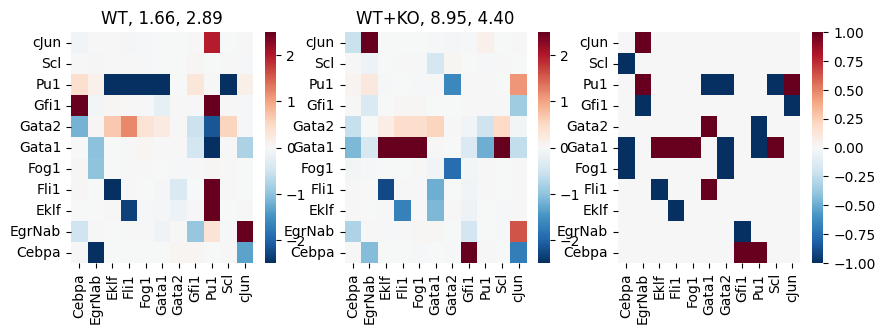

In [6]:
plt.figure(figsize = (10, 3))
plt.subplot(1, 3, 1)
A_infer = pd.read_csv(os.path.join(df_paths.iloc[i, 0], f"A_T_{T}_reg_0.001.csv"), index_col = 0)
A_infer_ko = pd.read_csv(os.path.join(df_paths.iloc[i, 0], f"A_T_{T}_ko{n_ko}_reg_0.001.csv"), index_col = 0)
# A_infer_ko = pd.read_csv("A_test.csv", index_col = 0)
sb.heatmap(A_infer, vmin = -2.5, vmax = 2.5, cmap = "RdBu_r")
plt.gca().invert_yaxis()
plt.title(f"WT, {AUPRC_ratio_pos(A_ref, A_infer):.2f}, {AUPRC_ratio_neg(A_ref, A_infer):.2f}")
plt.subplot(1, 3, 2)
sb.heatmap(A_infer_ko, vmin = -2.5, vmax = 2.5, cmap = "RdBu_r")
plt.gca().invert_yaxis()
plt.title(f"WT+KO, {AUPRC_ratio_pos(A_ref, A_infer_ko):.2f}, {AUPRC_ratio_neg(A_ref, A_infer_ko):.2f}")
plt.subplot(1, 3, 3)
sb.heatmap(A_ref, cmap = "RdBu_r")
plt.gca().invert_yaxis()

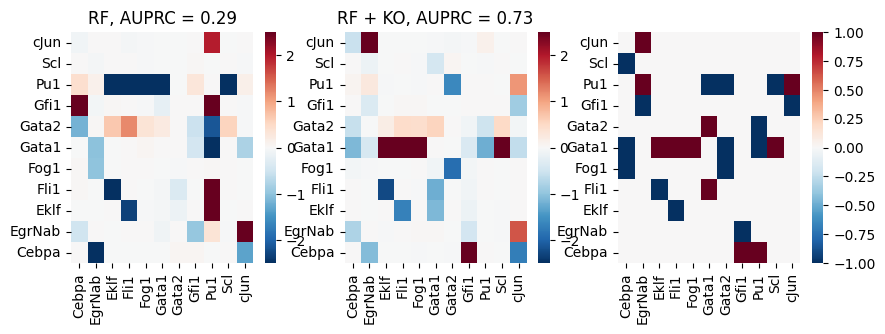

In [7]:
plt.figure(figsize = (10, 3))
plt.subplot(1, 3, 1)
A_infer = pd.read_csv(os.path.join(df_paths.iloc[i, 0], f"A_T_{T}_reg_0.001.csv"), index_col = 0)
A_infer_ko = pd.read_csv(os.path.join(df_paths.iloc[i, 0], f"A_T_{T}_ko{n_ko}_reg_0.001.csv"), index_col = 0)
# A_infer_ko = pd.read_csv("A_test.csv", index_col = 0)
sb.heatmap(A_infer, vmin = -2.5, vmax = 2.5, cmap = "RdBu_r")
plt.gca().invert_yaxis()
plt.title(f"RF, AUPRC = {AUPRC(A_ref, A_infer):.2f}")
plt.subplot(1, 3, 2)
sb.heatmap(A_infer_ko, vmin = -2.5, vmax = 2.5, cmap = "RdBu_r")
plt.gca().invert_yaxis()
plt.title(f"RF + KO, AUPRC = {AUPRC(A_ref, A_infer_ko):.2f}")
plt.subplot(1, 3, 3)
sb.heatmap(A_ref, cmap = "RdBu_r")
plt.gca().invert_yaxis()
plt.savefig("../figures/HSC_comparison.pdf")

In [8]:
ko_genes = pd.read_csv("../jobs/HSC_centralities.csv", index_col=0).index[:n_ko]
idx = np.where([i not in ko_genes for i in genes])[0]
AUPRC_ratio(A_ref.iloc[idx, idx], A_infer.iloc[idx, idx]), AUPRC_ratio(A_ref.iloc[idx, idx], A_infer_ko.iloc[idx, idx])

(1.0116, 2.3890219780219777)

In [9]:
ko_genes.values

array(['Gata1', 'Fli1', 'Fog1', 'Eklf', 'Scl'], dtype=object)

In [10]:
np.abs(A_ref.values).mean()

0.21487603305785125

In [11]:
AUPRC(A_ref, A_infer), AUPRC(A_ref, A_infer_ko)

(0.2936551841846041, 0.7271719997579134)

Text(0.5, 1.0, 'WT+KO, 3.38')

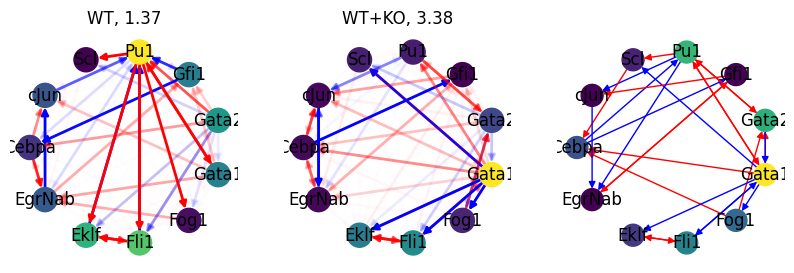

In [12]:
import networkx as nx

plt.figure(figsize = (10, 3))
plt.subplot(1, 3, 3)
g = nx.DiGraph(A_ref)
centralities = nx.centrality.eigenvector_centrality(g.reverse())
nx.set_node_attributes(g, centralities, name = "centrality")
edge_colors = ['blue' if g[u][v]['weight'] > 0 else 'red' for u, v in g.edges()]

pos = nx.shell_layout(g)
nx.draw(g, with_labels = True, node_color = [centralities[x] for x in g.nodes], edge_color = edge_colors, node_size = 2.5e2, pos=pos)

plt.subplot(1, 3, 1)
g = nx.DiGraph(A_infer)
weights = nx.get_edge_attributes(g, 'weight').values()
weights = np.abs(np.array(list(weights)))
# weights = np.abs(np.array(list(weights))), 0, 2.5)
# alpha_values = (weights - weights.min()) / (weights.max() - weights.min())
alpha_values = np.minimum(1, weights / np.quantile(weights, 0.95))
_g = nx.DiGraph(np.abs(A_infer))
centralities = nx.centrality.eigenvector_centrality(_g.reverse(), weight = 'weight')
nx.set_node_attributes(g, centralities, name = "centrality")
edge_colors = ['blue' if g[u][v]['weight'] > 0 else 'red' for u, v in g.edges()]
nx.draw_networkx_nodes(g, pos, node_color = [centralities[x] for x in g.nodes])
for (u, v, d), alpha, c in zip(g.edges(data=True), alpha_values, edge_colors):
    nx.draw_networkx_edges(g, pos, edgelist=[(u, v)], width=2, alpha=alpha, edge_color = c)
nx.draw_networkx_labels(g, pos)
plt.axis("off")
plt.title(f"WT, {AUPRC_ratio(A_ref, A_infer):.2f}")

plt.subplot(1, 3, 2)
g = nx.DiGraph(A_infer_ko)
weights = nx.get_edge_attributes(g, 'weight').values()
weights = np.abs(np.array(list(weights)))
# weights = np.clip(np.abs(np.array(list(weights))), 0, 2.5)
# alpha_values = (weights - weights.min()) / (weights.max() - weights.min())
alpha_values = np.minimum(1, weights / np.quantile(weights, 0.95))
_g = nx.DiGraph(np.abs(A_infer_ko))
centralities = nx.centrality.eigenvector_centrality(_g.reverse(), weight = 'weight')
nx.set_node_attributes(g, centralities, name = "centrality")
edge_colors = ['blue' if g[u][v]['weight'] > 0 else 'red' for u, v in g.edges()]
nx.draw_networkx_nodes(g, pos, node_color = [centralities[x] for x in g.nodes])
for (u, v, d), alpha, c in zip(g.edges(data=True), alpha_values, edge_colors):
    nx.draw_networkx_edges(g, pos, edgelist=[(u, v)], width=2, alpha=alpha, edge_color = c)
nx.draw_networkx_labels(g, pos)
plt.axis("off")
plt.title(f"WT+KO, {AUPRC_ratio(A_ref, A_infer_ko):.2f}")

In [14]:
_AUPRC = AUPRC
T = 5
df_scores = {"WT" : get_scores_df(f"A_T_{T}_reg")}
for i in range(len(genes)):
    df_scores[f"ko_{i+1}"] = get_scores_df(f"A_T_{T}_ko{i+1}_reg")

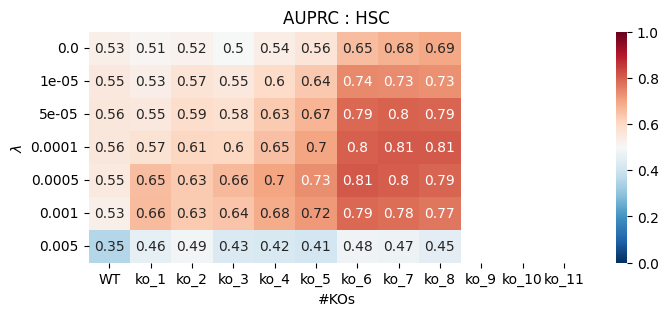

In [15]:
plt.figure(figsize = (8, 3))
_df = pd.DataFrame({k : v.mean(0) for (k, v) in df_scores.items()})
sb.heatmap(_df, vmin = 0, vmax = 1, cmap = "RdBu_r", annot = True)
plt.xlabel("#KOs"); plt.ylabel("$\lambda$"); plt.title(f"AUPRC : {backbone}")
plt.savefig(f"../figures/AUPRC_all_backbone_{backbone}.pdf")

In [16]:
df_scores_bicycle = pd.DataFrame(pd.Series({p : _AUPRC(A_ref, pd.DataFrame(np.load(p).T, index = A_ref.index, columns = A_ref.columns)) for p in glob.glob(os.path.join(f"/home/users/zys/zys/referencefitting/jobs/bicycle_output/plots/bicycle_BoolODE_{backbone}_*/*epoch5000.npy"))}))
df_scores_bicycle.index = df_scores_bicycle.index.str.split(backbone).str[1].str.split("_").str[1]

In [17]:
df_scores_simple = pd.DataFrame({method : get_scores_df_simple(method).values.flatten() for method in ["genie3", "dyngenie3", "sincerities", "glasso", ]})

In [18]:
df_scores_renge = {"WT" : get_scores_df_renge(f"A_renge_T_{T}_ko_0")}
for i in range(len(genes)):
    df_scores_renge[f"ko_{i+1}"] = get_scores_df_renge(f"A_renge_T_{T}_ko_{i+1}")

_df_renge = pd.DataFrame([df_scores_renge[k].mean(0).values for k in df_scores_renge.keys()])
_df = pd.DataFrame({k : v.mean(0) for (k, v) in df_scores.items()}).max(0)
_df_renge.index = _df.index
df_scores_bicycle.columns = [_df[~_df.isna()].index[-1], ]
_df_merged = pd.concat([_df, _df_renge, df_scores_bicycle.mean(0)], axis = 1, ignore_index = True)
_df_merged.columns = ["RF", "RENGE", "BICYCLE"]
_df_merged = pd.concat([_df_merged, pd.DataFrame(df_scores_simple.mean(0), columns = ["WT", ]).T], axis = 1)

In [19]:
_df_merged.columns=_df_merged.columns.str.upper()

Text(0.5, 1.0, 'AUPRC : HSC')

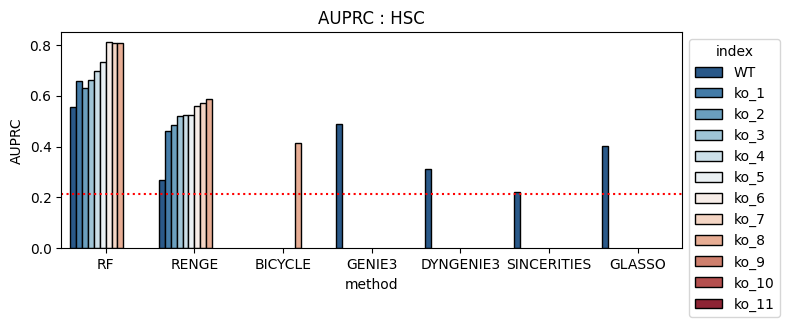

In [20]:
plt.figure(figsize = (8, 3))
sb.barplot(data = _df_merged.reset_index().melt(id_vars = "index", var_name = "method", value_name = "AUPRC"), x = 'method', y = 'AUPRC', hue = 'index', palette = "RdBu_r", edgecolor = 'k')
sb.move_legend(plt.gca(), "upper left", bbox_to_anchor=(1, 1))
plt.gca().axhline(y=np.mean(np.abs(A_ref)), color='red', ls=':')
plt.tight_layout()
plt.title(f"AUPRC : {backbone}")
# plt.savefig(f"../figures/AUPRC_vs_ko_methods_{backbone}.pdf")

In [21]:
df_scores["WT"].to_csv(f"../figures/AUPRC_WT_backbone_{backbone}.csv")

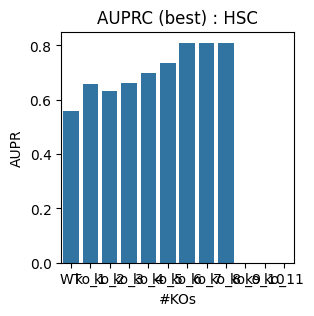

In [22]:
plt.figure(figsize = (3, 3))
sb.barplot(pd.DataFrame({k : v.mean(0) for (k, v) in df_scores.items()}).max(0))
plt.xlabel("#KOs"); plt.ylabel("AUPR"); plt.title(f"AUPRC (best) : {backbone}")
plt.savefig(f"../figures/AUPRC_best_backbone_{backbone}.pdf")

In [23]:
# Max possible AUPRC ratio
auprc_ratio_max = 1 / np.abs(A_ref.values).mean()

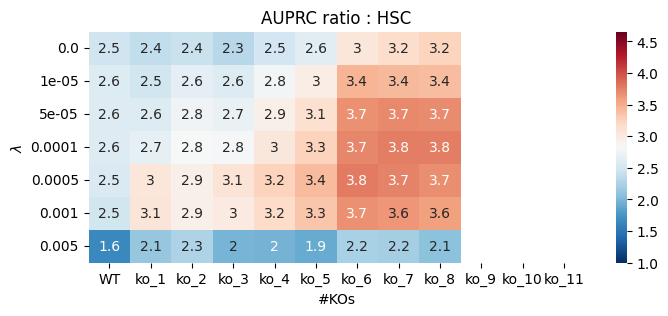

In [24]:
plt.figure(figsize = (8, 3))
sb.heatmap(pd.DataFrame({k : v.mean(0) / np.abs(A_ref.values).mean() for (k, v) in df_scores.items()}), vmin = 1, vmax = auprc_ratio_max, cmap = "RdBu_r", annot = True)
plt.xlabel("#KOs"); plt.ylabel("$\lambda$"); plt.title(f"AUPRC ratio : {backbone}")
plt.savefig(f"../figures/AUPRC_ratio_all_backbone_{backbone}.pdf")